# LSTM using pytorch

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set directory
import os
os.chdir('/content/drive/MyDrive/thesis-folder')

In [ ]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sc
import datetime
import calendar

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,  mean_squared_log_error

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 3.6 MB/s 


In [ ]:
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#International spring prediction

In [ ]:
#read International US spring season data
intl_spring_df = pd.read_csv('intermittent-result/International US/International spring community.csv')
intl_spring_df

,us_city,foreign_city,foreign_country,year,month,month_num,us_lat,us_long,foreign_lat,foreign_long,scheduled,charter,total,us_community,foreign_community,us_foreign_community
0,albany,montreal,canada,1990,april,4,42.651167,-73.754968,-73.610364,45.497216,0,183,183,5,1,5-1
1,allentown,freeport,the bahamas,1990,april,4,40.602206,-75.471279,-78.695362,26.535681,0,30,30,1,1,1-1
2,anchorage,amsterdam,netherlands,1990,april,4,61.216313,-149.894852,4.893604,52.372760,10007,0,10007,5,1,5-1
3,anchorage,brussels,belgium,1990,april,4,61.216313,-149.894852,4.359779,50.843735,3254,0,3254,5,2,5-2
4,anchorage,copenhagen,denmark,1990,april,4,61.216313,-149.894852,12.570072,55.686724,5739,0,5739,5,2,5-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108763,white plains,st. petersburg,russia,2019,may,5,41.033986,-73.762910,30.316229,59.938732,0,2,2,2,2,2-2
108764,white plains,toronto,canada,2019,may,5,41.033986,-73.762910,-79.383935,43.653482,0,11,11,2,1,2-1
108765,wichita,edmonton,canada,2019,may,5,37.692236,-97.337545,-113.507996,53.535411,140,0,140,5,5,5-5
108766,wichita,toronto,canada,2019,may,5,37.692236,-97.337545,-79.383935,43.653482,0,9,9,5,1,5-1


##Pre-processing - Spring

In [ ]:
#pre-processing
intl_spring_df.drop(columns=['foreign_country','us_lat','us_long','foreign_lat','foreign_long','us_community','foreign_community','us_foreign_community','scheduled', 'charter'], inplace=True)
intl_spring_df.sort_values(['year','month_num'],inplace=True)

#create date column from month and year
intl_spring_df['date'] = pd.to_datetime(intl_spring_df.year.astype(str) + '/' + intl_spring_df.month_num.astype(str) + '/01')
intl_spring_df.drop(columns='month', inplace=True)
intl_spring_df.rename(columns = {'month_num':'month'}, inplace=True)
intl_spring_df

,us_city,foreign_city,year,month,total,date
790,albany,freeport,1990,3,264,1990-03-01
791,albany,montreal,1990,3,237,1990-03-01
792,amarillo,manzanillo,1990,3,345,1990-03-01
793,anchorage,amsterdam,1990,3,14449,1990-03-01
794,anchorage,brussels,1990,3,3773,1990-03-01
...,...,...,...,...,...,...
108763,white plains,st. petersburg,2019,5,2,2019-05-01
108764,white plains,toronto,2019,5,11,2019-05-01
108765,wichita,edmonton,2019,5,140,2019-05-01
108766,wichita,toronto,2019,5,9,2019-05-01


In [ ]:
#set date as index
intl_spring_df = intl_spring_df.set_index(['date'])

intl_spring_df.index = pd.to_datetime(intl_spring_df.index)
#if not intl_spring_df.index.is_monotonic:
#    intl_spring_df = intl_spring_df.sort_index()

intl_spring_df

,us_city,foreign_city,year,month,total
date,,,,,
1990-03-01,albany,freeport,1990,3,264
1990-03-01,albany,montreal,1990,3,237
1990-03-01,amarillo,manzanillo,1990,3,345
1990-03-01,anchorage,amsterdam,1990,3,14449
1990-03-01,anchorage,brussels,1990,3,3773
...,...,...,...,...,...
2019-05-01,white plains,st. petersburg,2019,5,2
2019-05-01,white plains,toronto,2019,5,11
2019-05-01,wichita,edmonton,2019,5,140


##Feature encoding  -Spring

Binary encoding

In [ ]:
#encode US cities
#data = df_features['us_city']
data = intl_spring_df['us_city']
encoder= ce.BinaryEncoder(cols=['us_city'],return_df=True)
data_encoded=encoder.fit_transform(data) 
data_encoded

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9
date,,,,,,,,,,
1990-03-01,0,0,0,0,0,0,0,0,0,1
1990-03-01,0,0,0,0,0,0,0,0,0,1
1990-03-01,0,0,0,0,0,0,0,0,1,0
1990-03-01,0,0,0,0,0,0,0,0,1,1
1990-03-01,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-01,0,0,1,0,1,1,1,0,1,1
2019-05-01,0,0,1,0,1,1,1,0,1,1
2019-05-01,0,0,1,0,1,0,1,1,0,0


In [ ]:
#encode foreign cities
data1 = intl_spring_df['foreign_city']
encoder1= ce.BinaryEncoder(cols=['foreign_city'],return_df=True)
data_encoded1=encoder1.fit_transform(data1) 
data_encoded1

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,
1990-03-01,0,0,0,0,0,0,0,0,0,0,1
1990-03-01,0,0,0,0,0,0,0,0,0,1,0
1990-03-01,0,0,0,0,0,0,0,0,0,1,1
1990-03-01,0,0,0,0,0,0,0,0,1,0,0
1990-03-01,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,0,0,1,0,0,0,1,1,1,0,1
2019-05-01,0,0,0,0,0,0,1,1,1,1,0
2019-05-01,0,0,0,0,0,1,0,1,1,0,0


In [ ]:
#merge encoded values of US and foreign cities
df = pd.concat([data_encoded, data_encoded1], axis=1)
intl_spring_df = pd.concat([intl_spring_df, df], axis=1)

intl_spring_df

,us_city,foreign_city,year,month,total,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-03-01,albany,freeport,1990,3,264,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1990-03-01,albany,montreal,1990,3,237,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1990-03-01,amarillo,manzanillo,1990,3,345,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1990-03-01,anchorage,amsterdam,1990,3,14449,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
1990-03-01,anchorage,brussels,1990,3,3773,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,white plains,st. petersburg,2019,5,2,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1
2019-05-01,white plains,toronto,2019,5,11,0,0,1,0,1,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1,0
2019-05-01,wichita,edmonton,2019,5,140,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0


In [ ]:
#drop unwanted columns for model 
#df_features.drop(columns=['us_city', 'foreign_city', 'month','year','rolling_means'], inplace=True)
intl_spring_df.drop(columns=['us_city', 'foreign_city', 'month','year'], inplace=True)
intl_spring_df

,total,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,,,,,,,,,,,,
1990-03-01,264,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1990-03-01,237,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1990-03-01,345,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1990-03-01,14449,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
1990-03-01,3773,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,2,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1
2019-05-01,11,0,0,1,0,1,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1,0
2019-05-01,140,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0


##LSTM - Spring

In [ ]:
#set device for tensors
device = "cuda" if torch.cuda.is_available() else "cpu"
predictions_df=pd.DataFrame()

Switcher function for Normalisation


In [ ]:
#initialise train and test loaders in PyTorch
def initialise_data(X_train, X_val, X_test, y_train, y_val, y_test):
  scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)
  X_test_scaled = scaler.transform(X_test)

  y_train_scaled = scaler.fit_transform(y_train)
  y_val_scaled = scaler.transform(y_val)
  y_test_scaled = scaler.transform(y_test)

  batch_size = 64

  train_attribute = torch.Tensor(X_train_scaled)
  train_output = torch.Tensor(y_train_scaled)
  val_attribute = torch.Tensor(X_val_scaled)
  val_output = torch.Tensor(y_val_scaled)
  test_attribute = torch.Tensor(X_test_scaled)
  test_output = torch.Tensor(y_test_scaled)

  train = TensorDataset(train_attribute, train_output)
  val = TensorDataset(val_attribute, val_output)
  test = TensorDataset(test_attribute, test_output)

  train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
  val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
  master_test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

  print("Length of train_loader: ",len(train_loader))
  return train_loader, val_loader, test_loader, master_test_loader, scaler

In [ ]:
#class for LSTM model initialisation
class Lstm_forecast(nn.Module):
  
    def __init__(self, input, hidden, layer, output, dropout):      
        super(Lstm_forecast, self).__init__()
        self.hidden = hidden
        self.layer = layer
        self.lstm = nn.LSTM(
            input, hidden, layer, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden, output)

    def forward(self, x):
        h0 = torch.zeros(self.layer, x.size(0), self.hidden).requires_grad_()
        c0 = torch.zeros(self.layer, x.size(0), self.hidden).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

Switcher function for model

In [ ]:
#retrieve lstm model
def get_lstm_model(model, model_parameters):
    models = {
        "lstm": Lstm_forecast
    }
    return models.get(model.lower())(**model_parameters)

In [ ]:
#set optimizer attributes
class Opt_model:
   
    def __init__(self, model, loss_function, optimizer):   
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def step_optimizer(self, x, y):
        self.model.train()
        ydash = self.model(x)
        loss = self.loss_function(y, ydash)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.step_optimizer(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                val_loss_list = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    ydash = self.model(x_val)
                    val_loss = self.loss_function(y_val, ydash).item()
                    val_loss_list.append(val_loss)
                validation_loss = np.mean(val_loss_list)
                self.val_losses.append(validation_loss)

            print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

    def evaluate(self, test_loader, batch_size=1, n_features=1):      
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                ydash = self.model(x_test)
                predictions.append(ydash.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):     
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
#get the number of columns in training data
def get_input_shape(X_train):
  input_dim = len(X_train.columns)
  
  return input_dim

#calculate adjusted r^2 score
def adjusted_r2_score(df,score, test_data):
  n=len(df) 
  p=test_data.shape[1] 
  adjusted_r2 = 1-(1-score)*(n-1)/(n-p-1)
  return adjusted_r2

#calculate mae, rmse, r2, adjusted r2 score
def get_score(df, test_data):
    scores = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction),
                      'adjusted r2 score' : adjusted_r2_score(df, r2_score(df.value, df.prediction), test_data) }
    
    print("Mean Absolute Error:       ", scores["mae"])
    print("Root Mean Squared Error:   ", scores["rmse"])
    print("R^2 Score:                 ", scores["r2"])
    print("Adjusted R^2 score         ", scores["adjusted r2 score"])
    return scores

#perform inverse transformation on scaled data
def transform_data(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

#create a resultant data with actual and predicted values
def create_results(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals.round(4), "prediction": preds.round(4), "date":df_test.head(len(vals)).index})
    df_result = df_result.sort_index()
    df_result = transform_data(scaler, df_result, [["value", "prediction"]])
    return df_result

Length of train_loader:  849
train_loader 849
test_loader 566
val_loader 283
test_loader_one 36256
[1/2] Training loss: 0.0026	 Validation loss: 0.0021
[2/2] Training loss: 0.0022	 Validation loss: 0.0019


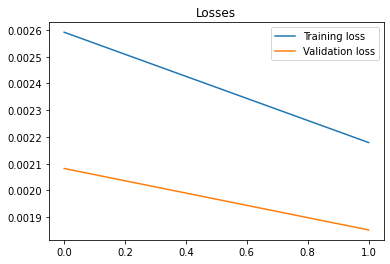

Mean Absolute Error:        8981.47992405383
Root Mean Squared Error:    15147.606406000536
R^2 Score:                  0.2910242919201236
Adjusted R^2 score          0.29061339359618255
MAE scores [8981.47992405383]
R2 scores [0.2910242919201236]
ADJ R2 scores [0.29061339359618255]


,value,prediction,date
0,14685.932617,168.827820,2012-03-01
1,8923.844727,3581.326416,2012-03-01
2,8364.417969,12616.056641,2012-03-01
3,11665.033203,5874.972656,2012-03-01
4,23049.351562,15189.416016,2012-03-01
...,...,...,...
36251,1.000000,-4614.264648,2019-05-01
36252,1.000000,2490.445801,2019-05-01
36253,140.856506,-1033.938110,2019-05-01
36254,1.000000,3441.469971,2019-05-01


In [ ]:
#perform training and prediction
mae_list = []
r2_score_list = []
adj_r2_score_list = []
mae_split_list = []
r2_split_list = []
adj_r2_split_list = []

input = len(X_train.columns)
output= 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 2
learning_rate = 1e-3
weight_decay = 1e-6

model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer_dim,
                'output' : output,
                'dropout' : dropout}

train_loader, val_loader, test_loader, master_test_loader, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val, y_test)
print("train_loader", len(train_loader))
print("test_loader", len(test_loader))
print("val_loader", len(val_loader))
print("master_test_loader", len(master_test_loader))
model = get_lstm_model('lstm', model_parameters)

loss_function = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Opt_model(model=model, loss_fn=loss_function, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
opt.plot_losses()

predictions, values = opt.evaluate(master_test_loader, batch_size=1, n_features=input)

df_result = create_results(predictions, values, X_test, scaler)
#predictions_df = pd.concat([predictions_df, df_result], axis=0)
scores = get_score(df_result, X_test)

mae_list.append(scores.get('mae'))
r2_score_list.append(scores.get('r2'))
adj_r2_score_list.append(scores.get('adjusted r2 score'))


print('MAE scores' , mae_list)
print('R2 scores' , r2_score_list)
print('ADJ R2 scores' ,adj_r2_score_list)
mae_split_list.append(min(mae_list))
r2_split_list.append(max(r2_score_list))
adj_r2_split_list.append(max(adj_r2_score_list))

df_result

Length of train_loader:  115
train_loader 115
test_loader 154
val_loader 38
test_loader_one 9888
[1/50] Training loss: 0.0030	 Validation loss: 0.0024
[2/50] Training loss: 0.0024	 Validation loss: 0.0022
[3/50] Training loss: 0.0024	 Validation loss: 0.0022
[4/50] Training loss: 0.0023	 Validation loss: 0.0021
[5/50] Training loss: 0.0022	 Validation loss: 0.0020
[6/50] Training loss: 0.0022	 Validation loss: 0.0019
[7/50] Training loss: 0.0021	 Validation loss: 0.0019
[8/50] Training loss: 0.0020	 Validation loss: 0.0018
[9/50] Training loss: 0.0020	 Validation loss: 0.0018
[10/50] Training loss: 0.0020	 Validation loss: 0.0017
[11/50] Training loss: 0.0019	 Validation loss: 0.0017
[12/50] Training loss: 0.0019	 Validation loss: 0.0016
[13/50] Training loss: 0.0018	 Validation loss: 0.0016
[14/50] Training loss: 0.0018	 Validation loss: 0.0016
[15/50] Training loss: 0.0017	 Validation loss: 0.0015
[16/50] Training loss: 0.0017	 Validation loss: 0.0015
[17/50] Training loss: 0.0016	 V

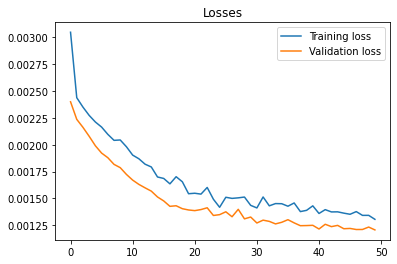

Mean Absolute Error:        7073.423748569388
Root Mean Squared Error:    10968.291131104428
R^2 Score:                  0.5150876760567276
Adjusted R^2 score          0.5140555294113993
MAE scores [7073.423748569388]
R2 scores [0.5150876760567276]
ADJ R2 scores [0.5140555294113993]
Length of train_loader:  231
train_loader 231
test_loader 154
val_loader 77
test_loader_one 9888
[1/50] Training loss: 0.0026	 Validation loss: 0.0029
[2/50] Training loss: 0.0023	 Validation loss: 0.0027
[3/50] Training loss: 0.0021	 Validation loss: 0.0025
[4/50] Training loss: 0.0021	 Validation loss: 0.0024
[5/50] Training loss: 0.0020	 Validation loss: 0.0023
[6/50] Training loss: 0.0019	 Validation loss: 0.0021
[7/50] Training loss: 0.0018	 Validation loss: 0.0021
[8/50] Training loss: 0.0018	 Validation loss: 0.0020
[9/50] Training loss: 0.0016	 Validation loss: 0.0019
[10/50] Training loss: 0.0016	 Validation loss: 0.0019
[11/50] Training loss: 0.0016	 Validation loss: 0.0018
[12/50] Training loss: 

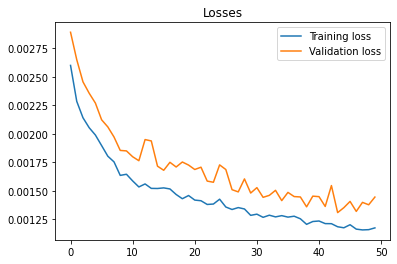

Mean Absolute Error:        6820.171303203275
Root Mean Squared Error:    11675.05675260984
R^2 Score:                  0.5360163238654762
Adjusted R^2 score          0.5350287243115713
MAE scores [7073.423748569388, 6820.171303203275]
R2 scores [0.5150876760567276, 0.5360163238654762]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713]
Length of train_loader:  347
train_loader 347
test_loader 154
val_loader 115
test_loader_one 9888
[1/50] Training loss: 0.0026	 Validation loss: 0.0029
[2/50] Training loss: 0.0022	 Validation loss: 0.0028
[3/50] Training loss: 0.0021	 Validation loss: 0.0026
[4/50] Training loss: 0.0020	 Validation loss: 0.0025
[5/50] Training loss: 0.0018	 Validation loss: 0.0023
[6/50] Training loss: 0.0017	 Validation loss: 0.0024
[7/50] Training loss: 0.0017	 Validation loss: 0.0023
[8/50] Training loss: 0.0017	 Validation loss: 0.0022
[9/50] Training loss: 0.0017	 Validation loss: 0.0020
[10/50] Training loss: 0.0016	 Validation loss: 0.0019
[11/50] Training lo

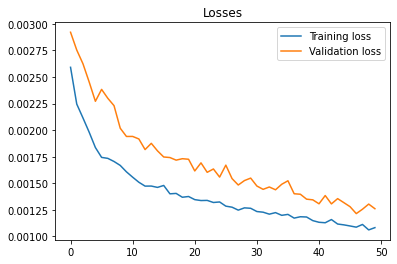

Mean Absolute Error:        6359.089001415382
Root Mean Squared Error:    10286.6067267842
R^2 Score:                  0.6326512048657589
Adjusted R^2 score          0.6318692948011106
MAE scores [7073.423748569388, 6820.171303203275, 6359.089001415382]
R2 scores [0.5150876760567276, 0.5360163238654762, 0.6326512048657589]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713, 0.6318692948011106]
Length of train_loader:  463
train_loader 463
test_loader 154
val_loader 154
test_loader_one 9888
[1/50] Training loss: 0.0027	 Validation loss: 0.0026
[2/50] Training loss: 0.0023	 Validation loss: 0.0024
[3/50] Training loss: 0.0021	 Validation loss: 0.0022
[4/50] Training loss: 0.0020	 Validation loss: 0.0021
[5/50] Training loss: 0.0019	 Validation loss: 0.0020
[6/50] Training loss: 0.0018	 Validation loss: 0.0019
[7/50] Training loss: 0.0017	 Validation loss: 0.0019
[8/50] Training loss: 0.0017	 Validation loss: 0.0018
[9/50] Training loss: 0.0016	 Validation loss: 0.0020
[10/50] Training

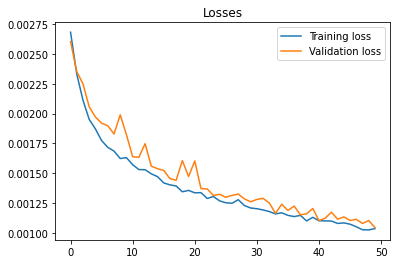

Mean Absolute Error:        6272.731015415332
Root Mean Squared Error:    9570.630126852182
R^2 Score:                  0.6544420443095689
Adjusted R^2 score          0.6537065165303778
MAE scores [7073.423748569388, 6820.171303203275, 6359.089001415382, 6272.731015415332]
R2 scores [0.5150876760567276, 0.5360163238654762, 0.6326512048657589, 0.6544420443095689]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713, 0.6318692948011106, 0.6537065165303778]
Length of train_loader:  579
train_loader 579
test_loader 154
val_loader 193
test_loader_one 9888
[1/50] Training loss: 0.0027	 Validation loss: 0.0023
[2/50] Training loss: 0.0023	 Validation loss: 0.0020
[3/50] Training loss: 0.0021	 Validation loss: 0.0019
[4/50] Training loss: 0.0020	 Validation loss: 0.0018
[5/50] Training loss: 0.0019	 Validation loss: 0.0017
[6/50] Training loss: 0.0018	 Validation loss: 0.0016
[7/50] Training loss: 0.0017	 Validation loss: 0.0016
[8/50] Training loss: 0.0017	 Validation loss: 0.0017
[9/50] Tra

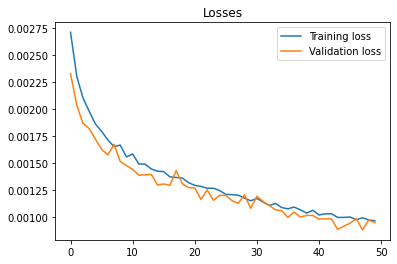

Mean Absolute Error:        6084.572511344063
Root Mean Squared Error:    9745.152185214522
R^2 Score:                  0.6488459888866491
Adjusted R^2 score          0.6480985497792722
MAE scores [7073.423748569388, 6820.171303203275, 6359.089001415382, 6272.731015415332, 6084.572511344063]
R2 scores [0.5150876760567276, 0.5360163238654762, 0.6326512048657589, 0.6544420443095689, 0.6488459888866491]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713, 0.6318692948011106, 0.6537065165303778, 0.6480985497792722]
Length of train_loader:  695
train_loader 695
test_loader 154
val_loader 231
test_loader_one 9888
[1/50] Training loss: 0.0028	 Validation loss: 0.0025
[2/50] Training loss: 0.0023	 Validation loss: 0.0022
[3/50] Training loss: 0.0021	 Validation loss: 0.0020
[4/50] Training loss: 0.0019	 Validation loss: 0.0020
[5/50] Training loss: 0.0018	 Validation loss: 0.0018
[6/50] Training loss: 0.0017	 Validation loss: 0.0018
[7/50] Training loss: 0.0016	 Validation loss: 0.0017
[8/50

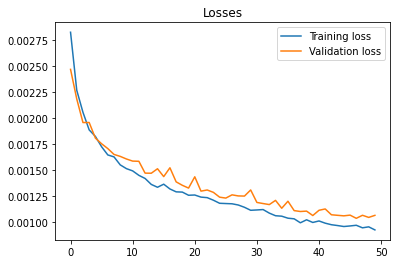

Mean Absolute Error:        6127.098076984323
Root Mean Squared Error:    10097.96247572153
R^2 Score:                  0.5717593369587712
Adjusted R^2 score          0.5708478172016391
MAE scores [7073.423748569388, 6820.171303203275, 6359.089001415382, 6272.731015415332, 6084.572511344063, 6127.098076984323]
R2 scores [0.5150876760567276, 0.5360163238654762, 0.6326512048657589, 0.6544420443095689, 0.6488459888866491, 0.5717593369587712]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713, 0.6318692948011106, 0.6537065165303778, 0.6480985497792722, 0.5708478172016391]
Length of train_loader:  811
train_loader 811
test_loader 154
val_loader 270
test_loader_one 9888
[1/50] Training loss: 0.0030	 Validation loss: 0.0023
[2/50] Training loss: 0.0023	 Validation loss: 0.0019
[3/50] Training loss: 0.0021	 Validation loss: 0.0018
[4/50] Training loss: 0.0019	 Validation loss: 0.0017
[5/50] Training loss: 0.0018	 Validation loss: 0.0017
[6/50] Training loss: 0.0018	 Validation loss: 0.0017


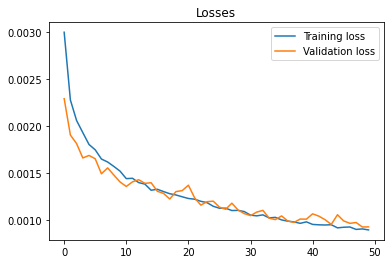

Mean Absolute Error:        6169.6038209515955
Root Mean Squared Error:    9980.298975173708
R^2 Score:                  0.6324341099620051
Adjusted R^2 score          0.6316517378060353
MAE scores [7073.423748569388, 6820.171303203275, 6359.089001415382, 6272.731015415332, 6084.572511344063, 6127.098076984323, 6169.6038209515955]
R2 scores [0.5150876760567276, 0.5360163238654762, 0.6326512048657589, 0.6544420443095689, 0.6488459888866491, 0.5717593369587712, 0.6324341099620051]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713, 0.6318692948011106, 0.6537065165303778, 0.6480985497792722, 0.5708478172016391, 0.6316517378060353]
Length of train_loader:  927
train_loader 927
test_loader 154
val_loader 309
test_loader_one 9888
[1/50] Training loss: 0.0026	 Validation loss: 0.0022
[2/50] Training loss: 0.0022	 Validation loss: 0.0019
[3/50] Training loss: 0.0019	 Validation loss: 0.0018
[4/50] Training loss: 0.0018	 Validation loss: 0.0017
[5/50] Training loss: 0.0017	 Validation loss: 

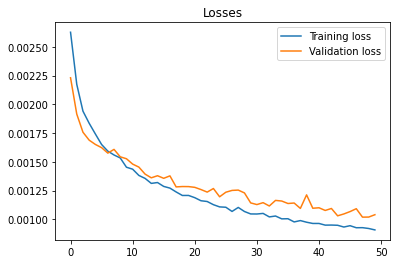

Mean Absolute Error:        7261.927212193705
Root Mean Squared Error:    10891.482690573543
R^2 Score:                  0.6134675578157256
Adjusted R^2 score          0.6126448149325034
MAE scores [7073.423748569388, 6820.171303203275, 6359.089001415382, 6272.731015415332, 6084.572511344063, 6127.098076984323, 6169.6038209515955, 7261.927212193705]
R2 scores [0.5150876760567276, 0.5360163238654762, 0.6326512048657589, 0.6544420443095689, 0.6488459888866491, 0.5717593369587712, 0.6324341099620051, 0.6134675578157256]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713, 0.6318692948011106, 0.6537065165303778, 0.6480985497792722, 0.5708478172016391, 0.6316517378060353, 0.6126448149325034]
Length of train_loader:  1042
train_loader 1042
test_loader 154
val_loader 347
test_loader_one 9888
[1/50] Training loss: 0.0025	 Validation loss: 0.0025
[2/50] Training loss: 0.0021	 Validation loss: 0.0023
[3/50] Training loss: 0.0019	 Validation loss: 0.0022
[4/50] Training loss: 0.0018	 Validation

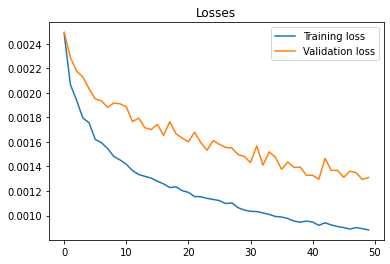

Mean Absolute Error:        7360.802713614627
Root Mean Squared Error:    12079.91096277833
R^2 Score:                  0.544373181229272
Adjusted R^2 score          0.5434033694317669
MAE scores [7073.423748569388, 6820.171303203275, 6359.089001415382, 6272.731015415332, 6084.572511344063, 6127.098076984323, 6169.6038209515955, 7261.927212193705, 7360.802713614627]
R2 scores [0.5150876760567276, 0.5360163238654762, 0.6326512048657589, 0.6544420443095689, 0.6488459888866491, 0.5717593369587712, 0.6324341099620051, 0.6134675578157256, 0.544373181229272]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713, 0.6318692948011106, 0.6537065165303778, 0.6480985497792722, 0.5708478172016391, 0.6316517378060353, 0.6126448149325034, 0.5434033694317669]
Length of train_loader:  1158
train_loader 1158
test_loader 154
val_loader 386
test_loader_one 9888
[1/50] Training loss: 0.0024	 Validation loss: 0.0027
[2/50] Training loss: 0.0020	 Validation loss: 0.0025
[3/50] Training loss: 0.0019	 Validati

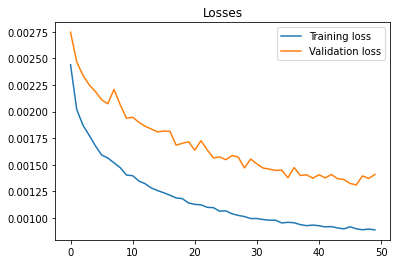

Mean Absolute Error:        7640.365776523851
Root Mean Squared Error:    12875.9374784113
R^2 Score:                  0.5545551395549952
Adjusted R^2 score          0.5536070002817999
MAE scores [7073.423748569388, 6820.171303203275, 6359.089001415382, 6272.731015415332, 6084.572511344063, 6127.098076984323, 6169.6038209515955, 7261.927212193705, 7360.802713614627, 7640.365776523851]
R2 scores [0.5150876760567276, 0.5360163238654762, 0.6326512048657589, 0.6544420443095689, 0.6488459888866491, 0.5717593369587712, 0.6324341099620051, 0.6134675578157256, 0.544373181229272, 0.5545551395549952]
ADJ R2 scores [0.5140555294113993, 0.5350287243115713, 0.6318692948011106, 0.6537065165303778, 0.6480985497792722, 0.5708478172016391, 0.6316517378060353, 0.6126448149325034, 0.5434033694317669, 0.5536070002817999]
minimum MAE:  6084.572511344063
Maximum R2 scores:  0.6544420443095689
Maximum adj R2 scores:  0.6537065165303778


In [ ]:
#perform training and prediction
mae_list = []
r2_score_list = []
adj_r2_score_list = []
mae_split_list = []
r2_split_list = []
adj_r2_split_list = []
test_data_ratio = 0.2
tscv_split = TimeSeriesSplit(max_train_size=None, n_splits=10)

X = intl_spring_df.drop(columns='total')
y = intl_spring_df[['total']]
val_ratio = test_data_ratio / (1 - test_data_ratio)

output = 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

r2_score_list = []
adj_r2_score_list = []
mae_list = []

for train_index_value, test_index_value in tscv_split.split(X):
  
  #print("TRAIN:", train_index_value, "TEST:", test_index_value) 
  X_train, X_test = X.iloc[train_index_value], X.iloc[test_index_value]
  y_train, y_test = y.iloc[train_index_value], y.iloc[test_index_value]
  val_ratio = test_data_ratio / (1 - test_data_ratio)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
  #print("X_train",X_train,"x_val",X_val)
  train_loader, val_loader, test_loader, master_test_loader, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val,y_test)
  print("train_loader", len(train_loader))
  print("test_loader", len(test_loader))
  print("val_loader", len(val_loader))
  print("master_test_loader", len(master_test_loader))


  input = get_input_shape(X_train)
  model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer,
                'output' : output,
                'dropout' : dropout}

  model_spring = get_lstm_model('lstm', model_parameters)
  loss_function = nn.MSELoss(reduction="mean")
  optimizer = optim.Adam(model_spring.parameters(), lr=learning_rate, weight_decay=weight_decay)
  opt = Opt_model(model=model_spring, loss_fn=loss_function, optimizer=optimizer)
  
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      test_loader_one,
      batch_size=1,
      n_features=input
  )
  df_result = create_results(predictions, values, X_test, scaler)
  #predictions_df = pd.concat([predictions_df, df_result], axis=0)
  scores = get_score(df_result, X_test) 
  mae_list.append(scores.get('mae'))
  r2_score_list.append(scores.get('r2'))
  adj_r2_score_list.append(scores.get('adjusted r2 score'))
  print('MAE scores' , mae_list)
  print('R2 scores' , r2_score_list)
  print('ADJ R2 scores' ,adj_r2_score_list)

print('minimum MAE: ', min(mae_list))
print('Maximum R2 scores: ', max(r2_score_list))
print('Maximum adj R2 scores: ', max(adj_r2_score_list))

In [ ]:
#save training data -- for plotting purpose
train_set = pd.concat([y_train, y_val], axis=0)
train_set.to_csv('intermittent-result/train-set/intl-spring-train-set.csv', index=False)

In [ ]:
df_result

,value,prediction,date
0,112.885193,7329.480469,2018-03-01
1,1455.507568,4840.034668,2018-03-01
2,56.942600,7804.992188,2018-03-01
3,140.856506,5371.489746,2018-03-01
4,1315.651001,4532.350586,2018-03-01
...,...,...,...
9883,1.000000,1539.421387,2019-05-01
9884,1.000000,2462.474365,2019-05-01
9885,140.856506,308.684296,2019-05-01
9886,1.000000,112.885193,2019-05-01


In [ ]:
#save the predictions
df_result.to_excel('results/intl-passenger-predictions-spring.xls', sheet_name='International spring', index=False)

# International Autumn Passengers 

In [ ]:
#read Autumn International US passengers data
intl_autumn_df = pd.read_csv('intermittent-result/International US/International autumn community.csv')
intl_autumn_df

,us_city,foreign_city,foreign_country,year,month,month_num,us_lat,us_long,foreign_lat,foreign_long,scheduled,charter,total,us_community,foreign_community,us_foreign_community
0,aguadilla,providenciales,turks and caicos islands,1990,november,11,18.449655,-67.118476,-72.300446,21.802061,0,50,50,0,7,0-7
1,aguadilla,st. lucia,saint lucia,1990,november,11,18.449655,-67.118476,-60.975036,13.825049,0,123,123,0,0,0-0
2,albany,cancun,mexico,1990,november,11,42.651167,-73.754968,-86.851047,21.161785,0,330,330,7,7,7-7
3,allentown,freeport,the bahamas,1990,november,11,40.602206,-75.471279,-78.695362,26.535681,0,138,138,0,0,0-0
4,anchorage,amsterdam,netherlands,1990,november,11,61.216313,-149.894852,4.893604,52.372760,5265,0,5265,9,9,9-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101076,white plains,naples,italy,2019,september,9,41.033986,-73.762910,14.248783,40.835934,0,14,14,0,0,0-0
101077,white plains,paris,france,2019,september,9,41.033986,-73.762910,2.351462,48.856697,0,2,2,0,7,0-7
101078,white plains,sonderborg,denmark,2019,september,9,41.033986,-73.762910,9.789800,54.908919,0,1,1,0,9,0-9
101079,white plains,toronto,canada,2019,september,9,41.033986,-73.762910,-79.383935,43.653482,0,19,19,0,7,0-7


##Pre-processing - Autumn

In [ ]:
#pre-processing
intl_autumn_df.drop(columns=['foreign_country','us_lat','us_long','foreign_lat','foreign_long','us_community','foreign_community','us_foreign_community','scheduled', 'charter'], inplace=True)
intl_autumn_df.sort_values(['year','month_num'],inplace=True)

#create date column from month and year
intl_autumn_df['date'] = pd.to_datetime(intl_autumn_df.year.astype(str) + '/' + intl_autumn_df.month_num.astype(str) + '/01')
intl_autumn_df.drop(columns='month', inplace=True)
intl_autumn_df.rename(columns = {'month_num':'month'}, inplace=True)
intl_autumn_df

,us_city,foreign_city,year,month,total,date
1573,aguadilla,port of spain,1990,9,387,1990-09-01
1574,anchorage,amsterdam,1990,9,8413,1990-09-01
1575,anchorage,brussels,1990,9,3554,1990-09-01
1576,anchorage,copenhagen,1990,9,8645,1990-09-01
1577,anchorage,dusseldorf,1990,9,4653,1990-09-01
...,...,...,...,...,...,...
97978,white plains,toronto,2019,11,60,2019-11-01
97979,white plains,zurich,2019,11,5,2019-11-01
97980,wichita,nice,2019,11,5,2019-11-01
97981,winston-salem,toronto,2019,11,5,2019-11-01


In [ ]:
#set date as index
intl_autumn_df = intl_autumn_df.set_index(['date'])
intl_autumn_df.index = pd.to_datetime(intl_autumn_df.index)

intl_autumn_df

,us_city,foreign_city,year,month,total
date,,,,,
1990-09-01,aguadilla,port of spain,1990,9,387
1990-09-01,anchorage,amsterdam,1990,9,8413
1990-09-01,anchorage,brussels,1990,9,3554
1990-09-01,anchorage,copenhagen,1990,9,8645
1990-09-01,anchorage,dusseldorf,1990,9,4653
...,...,...,...,...,...
2019-11-01,white plains,toronto,2019,11,60
2019-11-01,white plains,zurich,2019,11,5
2019-11-01,wichita,nice,2019,11,5


##Feature encoding  -Autumn

In [ ]:
#encode US city column using binary encoder
data = intl_autumn_df['us_city']
encoder= ce.BinaryEncoder(cols=['us_city'],return_df=True)
data_encoded=encoder.fit_transform(data) 
data_encoded

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9
date,,,,,,,,,,
1990-09-01,0,0,0,0,0,0,0,0,0,1
1990-09-01,0,0,0,0,0,0,0,0,1,0
1990-09-01,0,0,0,0,0,0,0,0,1,0
1990-09-01,0,0,0,0,0,0,0,0,1,0
1990-09-01,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2019-11-01,0,0,1,0,0,1,1,1,0,1
2019-11-01,0,0,1,0,0,1,1,1,0,1
2019-11-01,0,0,1,1,0,1,1,0,1,1


In [ ]:
#encode foreign city column using binary encoder
data1 = intl_autumn_df['foreign_city']
encoder1= ce.BinaryEncoder(cols=['foreign_city'],return_df=True)
data_encoded1=encoder1.fit_transform(data1) 
data_encoded1

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,
1990-09-01,0,0,0,0,0,0,0,0,0,0,1
1990-09-01,0,0,0,0,0,0,0,0,0,1,0
1990-09-01,0,0,0,0,0,0,0,0,0,1,1
1990-09-01,0,0,0,0,0,0,0,0,1,0,0
1990-09-01,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01,0,0,0,0,0,0,1,1,1,0,1
2019-11-01,0,0,0,0,0,0,0,1,1,1,1
2019-11-01,0,0,0,1,0,1,1,0,1,1,0


In [ ]:
#merge the encoded columns into a single dataframe
df = pd.concat([data_encoded, data_encoded1], axis=1)
intl_autumn_df = pd.concat([intl_autumn_df, df], axis=1)

intl_autumn_df

,us_city,foreign_city,year,month,total,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-09-01,aguadilla,port of spain,1990,9,387,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1990-09-01,anchorage,amsterdam,1990,9,8413,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1990-09-01,anchorage,brussels,1990,9,3554,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1990-09-01,anchorage,copenhagen,1990,9,8645,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1990-09-01,anchorage,dusseldorf,1990,9,4653,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01,white plains,toronto,2019,11,60,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,0,1
2019-11-01,white plains,zurich,2019,11,5,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1
2019-11-01,wichita,nice,2019,11,5,0,0,1,1,0,1,1,0,1,1,0,0,0,1,0,1,1,0,1,1,0


In [ ]:
#drop unwanted columns 
intl_autumn_df.drop(columns=['us_city', 'foreign_city', 'month','year'], inplace=True)
intl_autumn_df

,total,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,,,,,,,,,,,,
1990-09-01,387,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1990-09-01,8413,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1990-09-01,3554,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1990-09-01,8645,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1990-09-01,4653,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01,60,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,0,1
2019-11-01,5,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1
2019-11-01,5,0,0,1,1,0,1,1,0,1,1,0,0,0,1,0,1,1,0,1,1,0


##LSTM - Autumn

In [ ]:
# set device for tensors
device = "cuda" if torch.cuda.is_available() else "cpu"

Length of train_loader:  107
[1/50] Training loss: 0.0052	 Validation loss: 0.0047
[2/50] Training loss: 0.0045	 Validation loss: 0.0045
[3/50] Training loss: 0.0044	 Validation loss: 0.0043
[4/50] Training loss: 0.0043	 Validation loss: 0.0042
[5/50] Training loss: 0.0041	 Validation loss: 0.0040
[6/50] Training loss: 0.0040	 Validation loss: 0.0038
[7/50] Training loss: 0.0038	 Validation loss: 0.0036
[8/50] Training loss: 0.0037	 Validation loss: 0.0035
[9/50] Training loss: 0.0036	 Validation loss: 0.0034
[10/50] Training loss: 0.0034	 Validation loss: 0.0032
[11/50] Training loss: 0.0032	 Validation loss: 0.0032
[12/50] Training loss: 0.0031	 Validation loss: 0.0032
[13/50] Training loss: 0.0031	 Validation loss: 0.0029
[14/50] Training loss: 0.0031	 Validation loss: 0.0029
[15/50] Training loss: 0.0030	 Validation loss: 0.0030
[16/50] Training loss: 0.0028	 Validation loss: 0.0029
[17/50] Training loss: 0.0028	 Validation loss: 0.0029
[18/50] Training loss: 0.0028	 Validation los

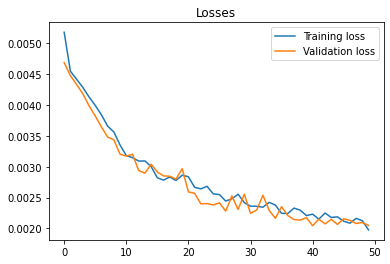

Mean Absolute Error:        6856.534087392915
Root Mean Squared Error:    12019.617709207767
R^2 Score:                  0.5428544192166883
Adjusted R^2 score          0.5418071783312897
MAE scores [6856.534087392915]
R2 scores [0.5428544192166883]
ADJ R2 scores [0.5418071783312897]
Length of train_loader:  215
[1/50] Training loss: 0.0041	 Validation loss: 0.0048
[2/50] Training loss: 0.0037	 Validation loss: 0.0045
[3/50] Training loss: 0.0035	 Validation loss: 0.0042
[4/50] Training loss: 0.0033	 Validation loss: 0.0039
[5/50] Training loss: 0.0030	 Validation loss: 0.0036
[6/50] Training loss: 0.0029	 Validation loss: 0.0035
[7/50] Training loss: 0.0028	 Validation loss: 0.0032
[8/50] Training loss: 0.0027	 Validation loss: 0.0032
[9/50] Training loss: 0.0025	 Validation loss: 0.0030
[10/50] Training loss: 0.0025	 Validation loss: 0.0030
[11/50] Training loss: 0.0024	 Validation loss: 0.0029
[12/50] Training loss: 0.0024	 Validation loss: 0.0028
[13/50] Training loss: 0.0023	 Valid

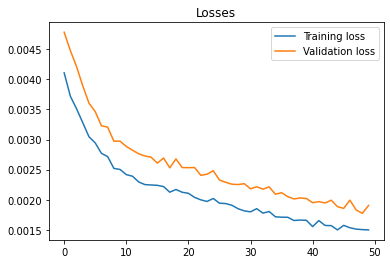

Mean Absolute Error:        6923.3458446295535
Root Mean Squared Error:    12270.936499694466
R^2 Score:                  0.5489901105622275
Adjusted R^2 score          0.5479569254767913
MAE scores [6856.534087392915, 6923.3458446295535]
R2 scores [0.5428544192166883, 0.5489901105622275]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913]
Length of train_loader:  323
[1/50] Training loss: 0.0041	 Validation loss: 0.0047
[2/50] Training loss: 0.0037	 Validation loss: 0.0042
[3/50] Training loss: 0.0033	 Validation loss: 0.0039
[4/50] Training loss: 0.0030	 Validation loss: 0.0035
[5/50] Training loss: 0.0028	 Validation loss: 0.0032
[6/50] Training loss: 0.0026	 Validation loss: 0.0032
[7/50] Training loss: 0.0026	 Validation loss: 0.0030
[8/50] Training loss: 0.0024	 Validation loss: 0.0031
[9/50] Training loss: 0.0024	 Validation loss: 0.0029
[10/50] Training loss: 0.0023	 Validation loss: 0.0028
[11/50] Training loss: 0.0023	 Validation loss: 0.0029
[12/50] Training loss: 0.0022	

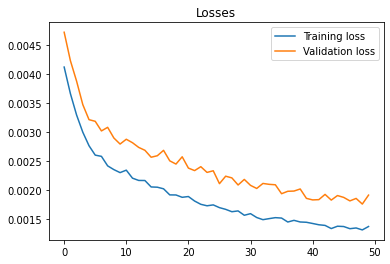

Mean Absolute Error:        5736.543416797174
Root Mean Squared Error:    9667.441662645082
R^2 Score:                  0.6340741341163283
Adjusted R^2 score          0.6332358617062097
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097]
Length of train_loader:  430
[1/50] Training loss: 0.0041	 Validation loss: 0.0033
[2/50] Training loss: 0.0035	 Validation loss: 0.0029
[3/50] Training loss: 0.0031	 Validation loss: 0.0027
[4/50] Training loss: 0.0029	 Validation loss: 0.0026
[5/50] Training loss: 0.0027	 Validation loss: 0.0024
[6/50] Training loss: 0.0026	 Validation loss: 0.0024
[7/50] Training loss: 0.0025	 Validation loss: 0.0022
[8/50] Training loss: 0.0024	 Validation loss: 0.0021
[9/50] Training loss: 0.0023	 Validation loss: 0.0021
[10/50] Training loss: 0.0022	 Validation loss: 0.0021
[11/50] Training loss: 0.002

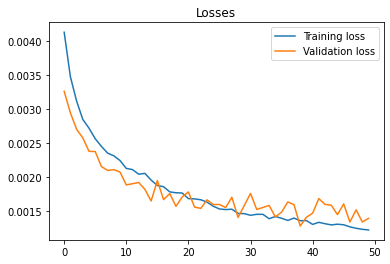

Mean Absolute Error:        6159.04158402195
Root Mean Squared Error:    9524.30523560912
R^2 Score:                  0.6970821151572402
Adjusted R^2 score          0.6963881830549496
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496]
Length of train_loader:  538
[1/50] Training loss: 0.0042	 Validation loss: 0.0035
[2/50] Training loss: 0.0033	 Validation loss: 0.0029
[3/50] Training loss: 0.0029	 Validation loss: 0.0026
[4/50] Training loss: 0.0027	 Validation loss: 0.0024
[5/50] Training loss: 0.0025	 Validation loss: 0.0023
[6/50] Training loss: 0.0024	 Validation loss: 0.0022
[7/50] Training loss: 0.0023	 Validation loss: 0.0021
[8/50] Training loss: 0.0022	 Validation loss: 0.0021
[9/50] Training loss: 0.0021	 Validation loss: 0.0020
[10/50] Training loss: 0.00

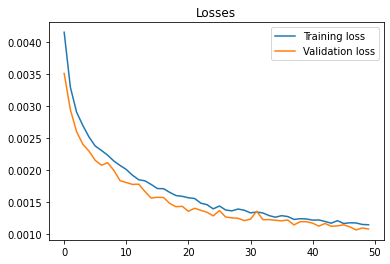

Mean Absolute Error:        5936.863447460209
Root Mean Squared Error:    8922.385393291735
R^2 Score:                  0.6971460562967657
Adjusted R^2 score          0.6964522706724865
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865]
Length of train_loader:  646
[1/50] Training loss: 0.0036	 Validation loss: 0.0030
[2/50] Training loss: 0.0029	 Validation loss: 0.0026
[3/50] Training loss: 0.0026	 Validation loss: 0.0024
[4/50] Training loss: 0.0024	 Validation loss: 0.0022
[5/50] Training loss: 0.0023	 Validation loss: 0.0021
[6/50] Training loss: 0.0022	 Validation loss: 0.0020
[7/50] Training loss: 0.0021	 Validation loss: 0.0019
[8/50] Training loss: 0.0020	 Validation loss: 0.0019
[9/50] Training loss

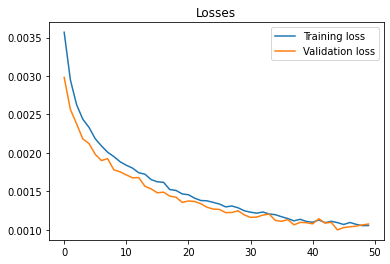

Mean Absolute Error:        6009.65675717266
Root Mean Squared Error:    9360.05879614697
R^2 Score:                  0.6708390704247492
Adjusted R^2 score          0.6700850200788258
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258]
Length of train_loader:  753
[1/50] Training loss: 0.0023	 Validation loss: 0.0018
[2/50] Training loss: 0.0019	 Validation loss: 0.0016
[3/50] Training loss: 0.0017	 Validation loss: 0.0015
[4/50] Training loss: 0.0015	 Validation loss: 0.0014
[5/50] Training loss: 0.0015	 Validation loss: 0.0013
[6/50] Training loss: 0.0014	 Validation loss: 0.0013
[7/50] Training loss: 0.0014	 Validation loss: 0.0013
[8/50] Training lo

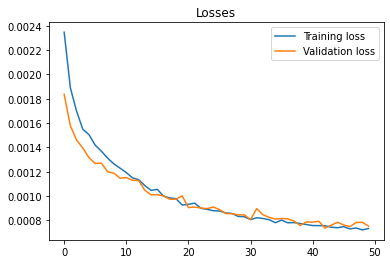

Mean Absolute Error:        6421.805349540731
Root Mean Squared Error:    10239.455001139026
R^2 Score:                  0.6408565879575359
Adjusted R^2 score          0.6400338529675837
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837]
Length of train_loader:  861
[1/50] Training loss: 0.0022	 Validation loss: 0.0019
[2/50] Training loss: 0.0018	 Validation loss: 0.0017
[3/50] Training loss: 0.0017	 Validation loss: 0.0016
[4/50] Training loss: 0.0015	 Validation loss: 0.0015
[5/50] Training loss: 0.0015	 Validation loss: 0.0014
[6/50] Training loss: 0.0014	 Validation loss: 0.0014
[7/50] Tra

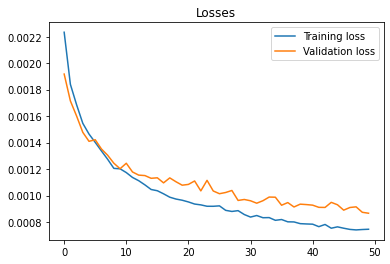

Mean Absolute Error:        6843.181031608934
Root Mean Squared Error:    11364.46030984816
R^2 Score:                  0.594460802582217
Adjusted R^2 score          0.5935317829306654
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829306654]
Length of train_loader:  969
[1/50] Training loss: 0.0023	 Validation loss: 0.0022
[2/50] Training loss: 0.0018	 Validation loss: 0.0019
[3/50] Training loss: 0.0016	 Validation loss: 0.0017
[4/50] Training loss: 0.0015	 Validation loss: 0.0017
[5/50] Training loss: 0.0014	 Validation loss: 0.0016
[6/50] T

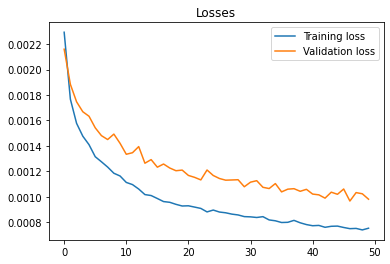

Mean Absolute Error:        7311.313289357135
Root Mean Squared Error:    11784.174605209555
R^2 Score:                  0.5919331835006412
Adjusted R^2 score          0.5909983735141149
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829306654, 0.5909983735141149]
Length of train_loader:  1076
[1/50] Training loss: 0.0021	 Validation loss: 0.0023
[2/50] Training loss: 0.0017	 Validation loss: 0.0021
[3/50] Training loss: 0.0016	 Validation loss: 0.0020
[4/50] Training loss: 0.0015	 Validation loss: 0.0019


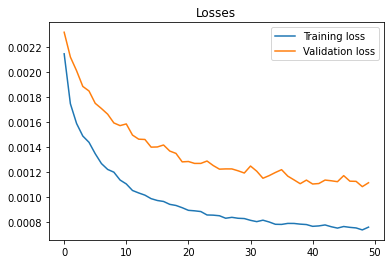

Mean Absolute Error:        7597.762612004393
Root Mean Squared Error:    12744.774155560694
R^2 Score:                  0.5785371513883377
Adjusted R^2 score          0.5775716534259896
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829306654, 0.5909983735141149, 0.5775716534259896]
minimum MAE:  5736.543416797174
Maximum R2 scores:  0.6971460562967657
Maximum adj R2 scores:  0.6964522706724865


In [ ]:
#train, test and evaluate the model
test_data_ratio = 0.2
tscv_split = TimeSeriesSplit(max_train_size=None, n_splits=10)

X = intl_autumn_df.drop(columns='total')
y = intl_autumn_df[['total']]
val_ratio = test_data_ratio / (1 - test_data_ratio)

output = 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

mae_list = []
r2_score_list = []
adj_r2_score_list = []
mae_split_list = []
r2_split_list = []
adj_r2_split_list = []

for train_index_value, test_index_value in tscv_split.split(X):
  #print("TRAIN:", train_index_value, "TEST:", test_index_value) 
  X_train, X_test = X.iloc[train_index_value], X.iloc[test_index_value]
  y_train, y_test = y.iloc[train_index_value], y.iloc[test_index_value]
  val_ratio = test_data_ratio / (1 - test_data_ratio)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
  #print("X_train",X_train,"x_val",X_val)
  train_loader, val_loader, test_loader, master_test_loader, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val,y_test)

  input = get_input_shape(X_train)
  model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer,
                'output' : output,
                'dropout' : dropout}

  model_autumn = get_lstm_model('lstm', model_parameters)
  loss_function = nn.MSELoss(reduction="mean")
  optimizer = optim.Adam(model_autumn.parameters(), lr=learning_rate, weight_decay=weight_decay)
  opt = Opt_model(model=model_autumn, loss_fn=loss_function, optimizer=optimizer)

  
  
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      test_loader_one,
      batch_size=1,
      n_features=input
  )
  df_result = create_results(predictions, values, X_test, scaler)
  #predictions_df = pd.concat([predictions_df, df_result], axis=0)
  scores = get_score(df_result, X_test) 
  mae_list.append(scores.get('mae'))
  r2_score_list.append(scores.get('r2'))
  adj_r2_score_list.append(scores.get('adjusted r2 score'))
  print('MAE scores' , mae_list)
  print('R2 scores' , r2_score_list)
  print('ADJ R2 scores' ,adj_r2_score_list)

print('minimum MAE: ', min(mae_list))
print('Maximum R2 scores: ', max(r2_score_list))
print('Maximum adj R2 scores: ', max(adj_r2_score_list))

In [ ]:
#save training dataset -- for plotting purpose
train_set = pd.concat([y_train, y_val], axis=0)
train_set.to_csv('intermittent-result/train-set/intl-autumn-train-set.csv', index=False)

In [ ]:
df_result.groupby('date').sum()

,value,prediction
date,,
2012-09-01,1.278870e+07,1.024380e+07
2012-10-01,1.358385e+07,1.104752e+07
2012-11-01,1.293276e+07,1.100119e+07
2013-09-01,1.444883e+07,1.166344e+07
2013-10-01,1.453596e+07,1.160969e+07
2013-11-01,1.344888e+07,1.158270e+07
2014-09-01,1.518208e+07,1.181709e+07
2014-10-01,1.517047e+07,1.176284e+07
2014-11-01,1.389511e+07,1.193548e+07


In [ ]:
#save results
df_result.to_excel('results/intl-passenger-predictions-autumn.xls', sheet_name='International autumn', index=False)

# International Summer prediction

In [ ]:
#read data
intl_summer_df = pd.read_csv('intermittent-result/International US/International summer community.csv')
intl_summer_df

,us_city,foreign_city,foreign_country,year,month,month_num,us_lat,us_long,foreign_lat,foreign_long,scheduled,charter,total,us_community,foreign_community,us_foreign_community
0,aguadilla,port of spain,trinidad and tobago,1990,august,8,18.449655,-67.118476,-61.518017,10.657268,0,467,467,6,6,6-6
1,albany,montreal,canada,1990,august,8,42.651167,-73.754968,-73.610364,45.497216,45,0,45,1,2,1-2
2,albany,toronto,canada,1990,august,8,42.651167,-73.754968,-79.383935,43.653482,91,0,91,1,2,1-2
3,anchorage,amsterdam,netherlands,1990,august,8,61.216313,-149.894852,4.893604,52.372760,15672,0,15672,3,3,3-3
4,anchorage,brussels,belgium,1990,august,8,61.216313,-149.894852,4.359779,50.843735,4120,0,4120,3,1,3-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111148,white plains,pristina,kosovo,2019,june,6,41.033986,-73.762910,21.164085,42.663877,0,7,7,2,2,2-2
111149,white plains,rome,italy,2019,june,6,41.033986,-73.762910,12.482932,41.893320,0,2,2,2,1,2-1
111150,white plains,shannon,ireland,2019,june,6,41.033986,-73.762910,-8.878837,52.710454,0,4,4,2,1,2-1
111151,white plains,toronto,canada,2019,june,6,41.033986,-73.762910,-79.383935,43.653482,0,16,16,2,2,2-2


## Pre-processing - Summer

In [ ]:
#pre-processing
intl_summer_df.drop(columns=['foreign_country','us_lat','us_long','foreign_lat','foreign_long','us_community','foreign_community','us_foreign_community','scheduled', 'charter'], inplace=True)
intl_summer_df.sort_values(['year','month_num'],inplace=True)

#create date column from month and year
intl_summer_df['date'] = pd.to_datetime(intl_summer_df.year.astype(str) + '/' + intl_summer_df.month_num.astype(str) + '/01')
intl_summer_df.drop(columns='month', inplace=True)
intl_summer_df.rename(columns = {'month_num':'month'}, inplace=True)
intl_summer_df

,us_city,foreign_city,year,month,total,date
1716,albuquerque,cancun,1990,6,421,1990-06-01
1717,anchorage,amsterdam,1990,6,12134,1990-06-01
1718,anchorage,brussels,1990,6,3234,1990-06-01
1719,anchorage,comox,1990,6,55,1990-06-01
1720,anchorage,copenhagen,1990,6,7214,1990-06-01
...,...,...,...,...,...,...
107576,white plains,tokyo,2019,8,3,2019-08-01
107577,white plains,toronto,2019,8,14,2019-08-01
107578,white plains,zurich,2019,8,2,2019-08-01
107579,wichita falls,toronto,2019,8,63,2019-08-01


In [ ]:
#set date as index
intl_summer_df = intl_summer_df.set_index(['date'])
intl_summer_df.index = pd.to_datetime(intl_summer_df.index)

intl_summer_df

,us_city,foreign_city,year,month,total
date,,,,,
1990-06-01,albuquerque,cancun,1990,6,421
1990-06-01,anchorage,amsterdam,1990,6,12134
1990-06-01,anchorage,brussels,1990,6,3234
1990-06-01,anchorage,comox,1990,6,55
1990-06-01,anchorage,copenhagen,1990,6,7214
...,...,...,...,...,...
2019-08-01,white plains,tokyo,2019,8,3
2019-08-01,white plains,toronto,2019,8,14
2019-08-01,white plains,zurich,2019,8,2


## Feature encoding - Summer

In [ ]:
#encode US city column using binary encoder
data = intl_summer_df['us_city']
encoder= ce.BinaryEncoder(cols=['us_city'],return_df=True)
data_encoded=encoder.fit_transform(data) 
data_encoded

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9
date,,,,,,,,,,
1990-06-01,0,0,0,0,0,0,0,0,0,1
1990-06-01,0,0,0,0,0,0,0,0,1,0
1990-06-01,0,0,0,0,0,0,0,0,1,0
1990-06-01,0,0,0,0,0,0,0,0,1,0
1990-06-01,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2019-08-01,0,0,1,0,1,0,1,0,0,0
2019-08-01,0,0,1,0,1,0,1,0,0,0
2019-08-01,0,0,1,0,1,0,1,0,0,0


In [ ]:
#encode foreign city column using binary encoder
data1 = intl_summer_df['foreign_city']
encoder1= ce.BinaryEncoder(cols=['foreign_city'],return_df=True)
data_encoded1=encoder1.fit_transform(data1) 
data_encoded1

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,
1990-06-01,0,0,0,0,0,0,0,0,0,0,1
1990-06-01,0,0,0,0,0,0,0,0,0,1,0
1990-06-01,0,0,0,0,0,0,0,0,0,1,1
1990-06-01,0,0,0,0,0,0,0,0,1,0,0
1990-06-01,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,0,0,0,0,0,0,0,1,1,0,1
2019-08-01,0,0,0,0,0,0,1,1,0,1,0
2019-08-01,0,0,0,0,0,0,0,1,1,1,1


In [ ]:
#merge encoded values into a single dataframe
df = pd.concat([data_encoded, data_encoded1], axis=1)
intl_summer_df = pd.concat([intl_summer_df, df], axis=1)

intl_summer_df

,us_city,foreign_city,year,month,total,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-06-01,albuquerque,cancun,1990,6,421,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1990-06-01,anchorage,amsterdam,1990,6,12134,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1990-06-01,anchorage,brussels,1990,6,3234,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1990-06-01,anchorage,comox,1990,6,55,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1990-06-01,anchorage,copenhagen,1990,6,7214,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,white plains,tokyo,2019,8,3,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1
2019-08-01,white plains,toronto,2019,8,14,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2019-08-01,white plains,zurich,2019,8,2,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1


In [ ]:
#drop unwanted columns
intl_summer_df.drop(columns=['us_city', 'foreign_city', 'month','year'], inplace=True)
intl_summer_df

,total,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,,,,,,,,,,,,
1990-06-01,421,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1990-06-01,12134,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1990-06-01,3234,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1990-06-01,55,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1990-06-01,7214,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,3,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1
2019-08-01,14,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2019-08-01,2,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1


## LSTM - Summer

Length of train_loader:  118
[1/50] Training loss: 0.0050	 Validation loss: 0.0046
[2/50] Training loss: 0.0046	 Validation loss: 0.0045
[3/50] Training loss: 0.0045	 Validation loss: 0.0044
[4/50] Training loss: 0.0044	 Validation loss: 0.0043
[5/50] Training loss: 0.0042	 Validation loss: 0.0041
[6/50] Training loss: 0.0042	 Validation loss: 0.0040
[7/50] Training loss: 0.0041	 Validation loss: 0.0039
[8/50] Training loss: 0.0039	 Validation loss: 0.0037
[9/50] Training loss: 0.0038	 Validation loss: 0.0037
[10/50] Training loss: 0.0037	 Validation loss: 0.0035
[11/50] Training loss: 0.0035	 Validation loss: 0.0034
[12/50] Training loss: 0.0036	 Validation loss: 0.0034
[13/50] Training loss: 0.0034	 Validation loss: 0.0033
[14/50] Training loss: 0.0034	 Validation loss: 0.0032
[15/50] Training loss: 0.0032	 Validation loss: 0.0031
[16/50] Training loss: 0.0032	 Validation loss: 0.0031
[17/50] Training loss: 0.0031	 Validation loss: 0.0029
[18/50] Training loss: 0.0031	 Validation los

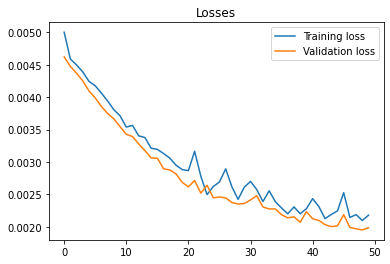

Mean Absolute Error:        7929.171336124365
Root Mean Squared Error:    13276.418510243218
R^2 Score:                  0.5452345687492948
Adjusted R^2 score          0.5442873287119743
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829306654, 0.5909983735141149, 0.5775716534259896, 0.5442873287119743]
Length of train_loader:  236
[1/50] Training loss: 0.0048	 Validation loss: 0.0053
[2/50] Training loss: 0.0045	 Validation loss

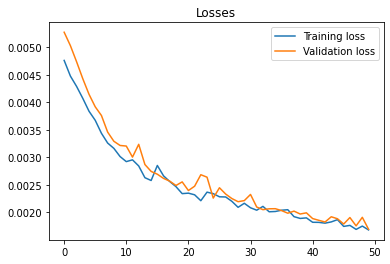

Mean Absolute Error:        7522.173715435128
Root Mean Squared Error:    12260.497606827408
R^2 Score:                  0.6443156732315801
Adjusted R^2 score          0.6435748112139114
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829306654, 0.5909983735141149, 0.5775716534259896, 0.5442873287119743, 0.6435748112139114]
Length of train_loader:  355
[1/50] Training loss: 0.0047	 Validation

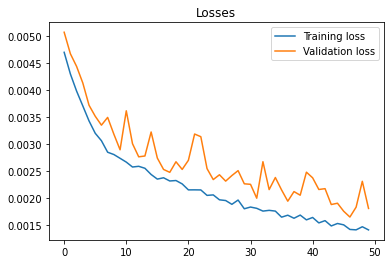

Mean Absolute Error:        6968.0082750505435
Root Mean Squared Error:    11561.14262813991
R^2 Score:                  0.6479645639523565
Adjusted R^2 score          0.6472313022823505
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829306654, 0.5909983735141149, 0.5775716534259896, 0.5442873287119743, 0.6435748112139114, 0.6472313022823505]
Length of

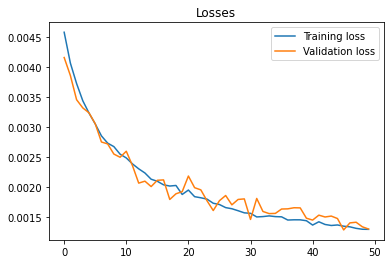

Mean Absolute Error:        7434.4329605230905
Root Mean Squared Error:    10978.273201971837
R^2 Score:                  0.6637221392233641
Adjusted R^2 score          0.6630216993229168
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829306654, 0.5909983735141149, 0.5775716534259896, 0.5442873287119743, 0.643574

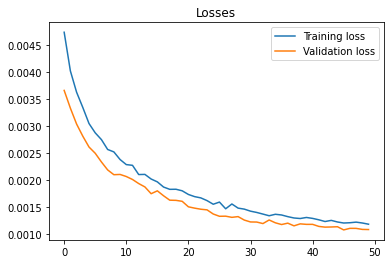

Mean Absolute Error:        6368.686902281035
Root Mean Squared Error:    9741.856510110267
R^2 Score:                  0.7196528973349225
Adjusted R^2 score          0.7190689567322677
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829306654, 0.5909983735141149, 0.577571653

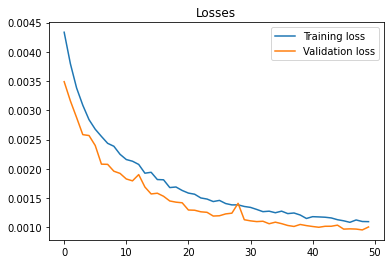

Mean Absolute Error:        5849.544024149955
Root Mean Squared Error:    9267.344931974763
R^2 Score:                  0.7138686127628654
Adjusted R^2 score          0.7132726239578684
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.6700850200788258, 0.6400338529675837, 0.5935317829

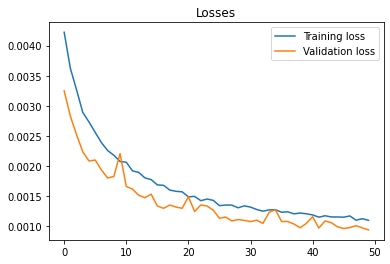

Mean Absolute Error:        6553.209890372396
Root Mean Squared Error:    10582.13984263733
R^2 Score:                  0.6948224281100064
Adjusted R^2 score          0.6941867676250143
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654, 0.6948224281100064]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.6963881830549496, 0.6964522706724865, 0.67008502007

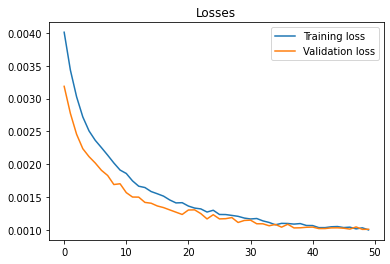

Mean Absolute Error:        7432.561068068019
Root Mean Squared Error:    11895.098066380197
R^2 Score:                  0.6478173393970421
Adjusted R^2 score          0.6470837710700572
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654, 0.6948224281100064, 0.6478173393970421]
ADJ R2 scores [0.5418071783312897, 0.5479569254767913, 0.6332358617062097, 0.69638818305

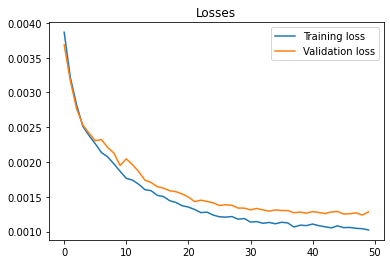

Mean Absolute Error:        7672.887765336395
Root Mean Squared Error:    12293.65326968241
R^2 Score:                  0.6410477484540262
Adjusted R^2 score          0.6403000796102982
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654, 0.6948224281100064, 0.6478173393970421, 0.6410477484540262]
ADJ R2 scores [0.5418071783312897, 0.5479569254767

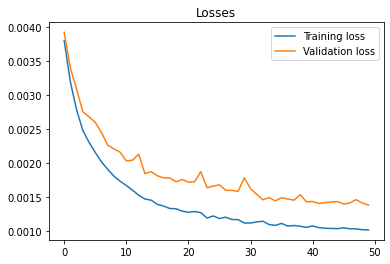

Mean Absolute Error:        7900.657045738714
Root Mean Squared Error:    12729.561207180497
R^2 Score:                  0.6526016470751779
Adjusted R^2 score          0.6518780440786076
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654, 0.6948224281100064, 0.6478173393970421, 0.6410477484540262, 0.6526016470751779]
ADJ R2 sco

In [ ]:
#train, test and evaluate the model
test_data_ratio = 0.2
tscv_split = TimeSeriesSplit(max_train_size=None, n_splits=10)

X = intl_summer_df.drop(columns='total')
y = intl_summer_df[['total']]
val_ratio = test_data_ratio / (1 - test_data_ratio)

output = 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

for train_index_value, test_index_value in tscv_split.split(X):
  #print("TRAIN:", train_index_value, "TEST:", test_index_value) 
  X_train, X_test = X.iloc[train_index_value], X.iloc[test_index_value]
  y_train, y_test = y.iloc[train_index_value], y.iloc[test_index_value]
  val_ratio = test_data_ratio / (1 - test_data_ratio)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
  #print("X_train",X_train,"x_val",X_val)
  train_loader, val_loader, test_loader, master_test_loader, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val,y_test)

  input = get_input_shape(X_train)
  model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer,
                'output' : output,
                'dropout' : dropout}

  model_summer = get_lstm_model('lstm', model_parameters)
  loss_function = nn.MSELoss(reduction="mean")
  optimizer = optim.Adam(model_summer.parameters(), lr=learning_rate, weight_decay=weight_decay)
  opt = Opt_model(model=model_summer, loss_fn=loss_function, optimizer=optimizer)

  
  
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      test_loader_one,
      batch_size=1,
      n_features=input
  )
  df_result = create_results(predictions, values, X_test, scaler)
  #predictions_df = pd.concat([predictions_df, df_result], axis=0)
  scores = get_score(df_result, X_test) 
  mae_list.append(scores.get('mae'))
  r2_score_list.append(scores.get('r2'))
  adj_r2_score_list.append(scores.get('adjusted r2 score'))
  print('MAE scores' , mae_list)
  print('R2 scores' , r2_score_list)
  print('ADJ R2 scores' ,adj_r2_score_list)

In [ ]:
#save training set for plotting purpose
train_set = pd.concat([y_train, y_val], axis=0)
train_set.to_csv('intermittent-result/train-set/intl-summer-train-set.csv', index=False)

In [ ]:
#save results
df_result.to_excel('results/intl-passenger-predictions-summer.xls', sheet_name='International summer', index=False)

#International Winter Prediction

In [ ]:
#read data
intl_winter_df = pd.read_csv('intermittent-result/International US/International winter community.csv')
intl_winter_df

,us_city,foreign_city,foreign_country,year,month,month_num,us_lat,us_long,foreign_lat,foreign_long,scheduled,charter,total,us_community,foreign_community,us_foreign_community
0,albany,montreal,canada,1990,december,12,42.651167,-73.754968,-73.610364,45.497216,108,0,108,0,0,0-0
1,anchorage,amsterdam,netherlands,1990,december,12,61.216313,-149.894852,4.893604,52.372760,6028,0,6028,4,0,4-0
2,anchorage,copenhagen,denmark,1990,december,12,61.216313,-149.894852,12.570072,55.686724,4559,0,4559,4,3,4-3
3,anchorage,dusseldorf,germany,1990,december,12,61.216313,-149.894852,6.776314,51.225402,1736,0,1736,4,5,4-5
4,anchorage,london,united kingdom,1990,december,12,61.216313,-149.894852,-0.127647,51.507322,16032,0,16032,4,0,4-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108980,white plains,toronto,canada,2019,january,1,41.033986,-73.762910,-79.383935,43.653482,0,4,4,3,0,3-0
108981,wilmington,goose bay,canada,2019,january,1,39.745947,-75.546589,-60.416667,53.333333,0,2,2,3,0,3-0
108982,wilmington,guatemala city,guatemala,2019,january,1,39.745947,-75.546589,-90.518519,14.622233,0,2,2,3,5,3-5
108983,wilmington,providenciales,turks and caicos islands,2019,january,1,39.745947,-75.546589,-72.300446,21.802061,0,4,4,3,0,3-0


##Pre-processing - Winter

In [ ]:
#pre-processing
intl_winter_df.drop(columns=['foreign_country','us_lat','us_long','foreign_lat','foreign_long','us_community','foreign_community','us_foreign_community','scheduled', 'charter'], inplace=True)
intl_winter_df.sort_values(['year','month_num'],inplace=True)

#create date column from month and year
intl_winter_df['date'] = pd.to_datetime(intl_winter_df.year.astype(str) + '/' + intl_winter_df.month_num.astype(str) + '/01')
intl_winter_df.drop(columns='month', inplace=True)
intl_winter_df.rename(columns = {'month_num':'month'}, inplace=True)
intl_winter_df

,us_city,foreign_city,year,month,total,date
1710,albany,freeport,1990,1,88,1990-01-01
1711,albany,montreal,1990,1,56,1990-01-01
1712,anchorage,amsterdam,1990,1,4995,1990-01-01
1713,anchorage,brussels,1990,1,3887,1990-01-01
1714,anchorage,copenhagen,1990,1,7012,1990-01-01
...,...,...,...,...,...,...
105774,white plains,seoul,2019,12,2,2019-12-01
105775,white plains,st. johns,2019,12,14,2019-12-01
105776,white plains,st. kitts,2019,12,12,2019-12-01
105777,white plains,toronto,2019,12,68,2019-12-01


In [ ]:
#set date as index
intl_winter_df = intl_winter_df.set_index(['date'])
intl_winter_df.index = pd.to_datetime(intl_winter_df.index)

intl_winter_df

,us_city,foreign_city,year,month,total
date,,,,,
1990-01-01,albany,freeport,1990,1,88
1990-01-01,albany,montreal,1990,1,56
1990-01-01,anchorage,amsterdam,1990,1,4995
1990-01-01,anchorage,brussels,1990,1,3887
1990-01-01,anchorage,copenhagen,1990,1,7012
...,...,...,...,...,...
2019-12-01,white plains,seoul,2019,12,2
2019-12-01,white plains,st. johns,2019,12,14
2019-12-01,white plains,st. kitts,2019,12,12


## Feature encoding - Winter

In [ ]:
#encode US city column using binary encoder
data = intl_winter_df['us_city']
encoder= ce.BinaryEncoder(cols=['us_city'],return_df=True)
data_encoded=encoder.fit_transform(data) 
data_encoded

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9
date,,,,,,,,,,
1990-01-01,0,0,0,0,0,0,0,0,0,1
1990-01-01,0,0,0,0,0,0,0,0,0,1
1990-01-01,0,0,0,0,0,0,0,0,1,0
1990-01-01,0,0,0,0,0,0,0,0,1,0
1990-01-01,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-01,0,0,1,1,0,0,1,1,0,0
2019-12-01,0,0,1,1,0,0,1,1,0,0
2019-12-01,0,0,1,1,0,0,1,1,0,0


In [ ]:
#encode Foreign city column using binary encoder
data1 = intl_winter_df['foreign_city']
encoder1= ce.BinaryEncoder(cols=['foreign_city'],return_df=True)
data_encoded1=encoder1.fit_transform(data1) 
data_encoded1

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,
1990-01-01,0,0,0,0,0,0,0,0,0,0,1
1990-01-01,0,0,0,0,0,0,0,0,0,1,0
1990-01-01,0,0,0,0,0,0,0,0,0,1,1
1990-01-01,0,0,0,0,0,0,0,0,1,0,0
1990-01-01,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,0,0,0,0,0,0,0,1,1,0,0
2019-12-01,0,0,0,1,0,0,1,0,1,0,1
2019-12-01,0,0,0,0,0,1,1,0,0,0,1


In [ ]:
#merge encoded values into a single dataframe
df = pd.concat([data_encoded, data_encoded1], axis=1)
intl_winter_df = pd.concat([intl_winter_df, df], axis=1)

intl_winter_df

,us_city,foreign_city,year,month,total,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-01,albany,freeport,1990,1,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1990-01-01,albany,montreal,1990,1,56,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1990-01-01,anchorage,amsterdam,1990,1,4995,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1990-01-01,anchorage,brussels,1990,1,3887,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1990-01-01,anchorage,copenhagen,1990,1,7012,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,white plains,seoul,2019,12,2,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0
2019-12-01,white plains,st. johns,2019,12,14,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1
2019-12-01,white plains,st. kitts,2019,12,12,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1


In [ ]:
#drop unwanted columns
intl_winter_df.drop(columns=['us_city', 'foreign_city', 'month','year'], inplace=True)
intl_winter_df

,total,us_city_0,us_city_1,us_city_2,us_city_3,us_city_4,us_city_5,us_city_6,us_city_7,us_city_8,us_city_9,foreign_city_0,foreign_city_1,foreign_city_2,foreign_city_3,foreign_city_4,foreign_city_5,foreign_city_6,foreign_city_7,foreign_city_8,foreign_city_9,foreign_city_10
date,,,,,,,,,,,,,,,,,,,,,,
1990-01-01,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1990-01-01,56,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1990-01-01,4995,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1990-01-01,3887,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1990-01-01,7012,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,2,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0
2019-12-01,14,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1
2019-12-01,12,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1


## LSTM - Winter

Length of train_loader:  116
[1/50] Training loss: 0.0037	 Validation loss: 0.0028
[2/50] Training loss: 0.0033	 Validation loss: 0.0027
[3/50] Training loss: 0.0032	 Validation loss: 0.0026
[4/50] Training loss: 0.0031	 Validation loss: 0.0025
[5/50] Training loss: 0.0029	 Validation loss: 0.0024
[6/50] Training loss: 0.0028	 Validation loss: 0.0024
[7/50] Training loss: 0.0026	 Validation loss: 0.0022
[8/50] Training loss: 0.0026	 Validation loss: 0.0022
[9/50] Training loss: 0.0025	 Validation loss: 0.0022
[10/50] Training loss: 0.0024	 Validation loss: 0.0021
[11/50] Training loss: 0.0025	 Validation loss: 0.0020
[12/50] Training loss: 0.0023	 Validation loss: 0.0021
[13/50] Training loss: 0.0024	 Validation loss: 0.0020
[14/50] Training loss: 0.0023	 Validation loss: 0.0021
[15/50] Training loss: 0.0023	 Validation loss: 0.0019
[16/50] Training loss: 0.0023	 Validation loss: 0.0019
[17/50] Training loss: 0.0021	 Validation loss: 0.0019
[18/50] Training loss: 0.0022	 Validation los

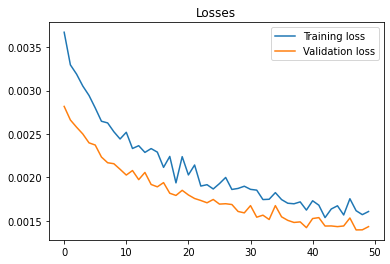

Mean Absolute Error:        6358.949627790897
Root Mean Squared Error:    10165.108016183907
R^2 Score:                  0.5327414255782735
Adjusted R^2 score          0.5317487669983184
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654, 0.6948224281100064, 0.6478173393970421, 0.6410477484540262, 0.652601647

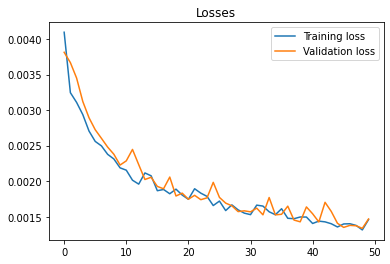

Mean Absolute Error:        5857.161016707778
Root Mean Squared Error:    9837.60874361069
R^2 Score:                  0.5992236393205121
Adjusted R^2 score          0.598372217613454
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654, 0.6948224281100064, 0.6478173393970421, 0.6410477484540

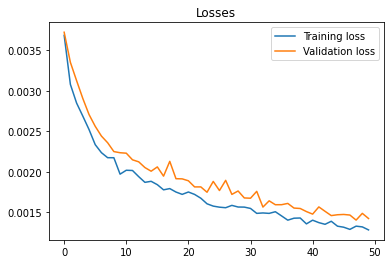

Mean Absolute Error:        5657.775210509835
Root Mean Squared Error:    9322.260170436484
R^2 Score:                  0.6449196945940664
Adjusted R^2 score          0.6441653510013983
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778, 5657.775210509835]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654, 0.6948224281100064, 0.647817339397

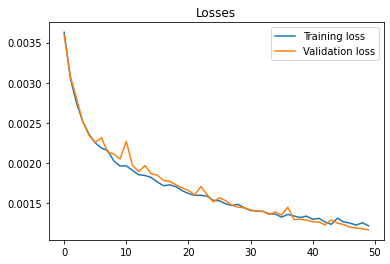

Mean Absolute Error:        5259.07838330048
Root Mean Squared Error:    8317.263092006477
R^2 Score:                  0.7221228913504374
Adjusted R^2 score          0.7215325606188602
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778, 5657.775210509835, 5259.07838330048]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.7138686127628654, 0.694822428110006

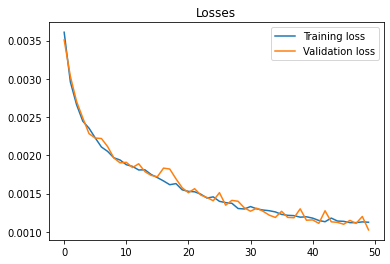

Mean Absolute Error:        5255.211674318191
Root Mean Squared Error:    8146.174130517139
R^2 Score:                  0.7077452137272855
Adjusted R^2 score          0.7071243386122903
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778, 5657.775210509835, 5259.07838330048, 5255.211674318191]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225, 0.713868612762865

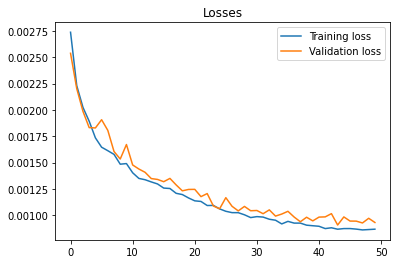

Mean Absolute Error:        5351.241244539527
Root Mean Squared Error:    8481.960615320526
R^2 Score:                  0.6586083394439819
Adjusted R^2 score          0.6578830764321786
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778, 5657.775210509835, 5259.07838330048, 5255.211674318191, 5351.241244539527]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641, 0.7196528973349225

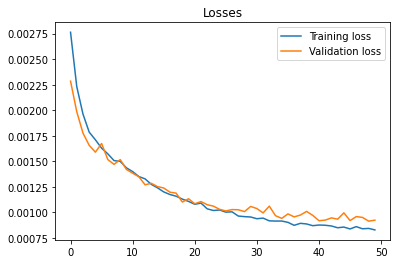

Mean Absolute Error:        5711.815503874255
Root Mean Squared Error:    8989.968900263375
R^2 Score:                  0.6422665866376909
Adjusted R^2 score          0.6415066067003506
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778, 5657.775210509835, 5259.07838330048, 5255.211674318191, 5351.241244539527, 5711.815503874255]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 0.6637221392233641,

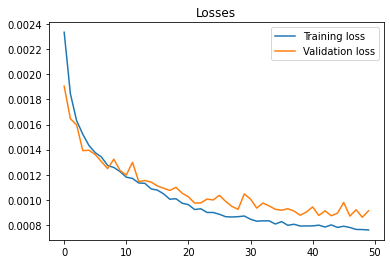

Mean Absolute Error:        6349.720626683387
Root Mean Squared Error:    10421.457659034098
R^2 Score:                  0.5684381656158901
Adjusted R^2 score          0.567521342295499
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778, 5657.775210509835, 5259.07838330048, 5255.211674318191, 5351.241244539527, 5711.815503874255, 6349.720626683387]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 0.6479645639523565, 

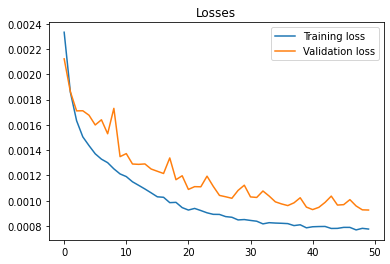

Mean Absolute Error:        7058.593702108356
Root Mean Squared Error:    11157.967790701312
R^2 Score:                  0.5838205587909815
Adjusted R^2 score          0.5829364143028288
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778, 5657.775210509835, 5259.07838330048, 5255.211674318191, 5351.241244539527, 5711.815503874255, 6349.720626683387, 7058.593702108356]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0.6443156732315801, 

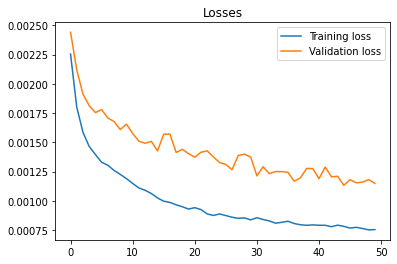

Mean Absolute Error:        7098.358386326116
Root Mean Squared Error:    11546.195321210345
R^2 Score:                  0.5653032904258518
Adjusted R^2 score          0.5643798072795638
MAE scores [6856.534087392915, 6923.3458446295535, 5736.543416797174, 6159.04158402195, 5936.863447460209, 6009.65675717266, 6421.805349540731, 6843.181031608934, 7311.313289357135, 7597.762612004393, 7929.171336124365, 7522.173715435128, 6968.0082750505435, 7434.4329605230905, 6368.686902281035, 5849.544024149955, 6553.209890372396, 7432.561068068019, 7672.887765336395, 7900.657045738714, 6358.949627790897, 5857.161016707778, 5657.775210509835, 5259.07838330048, 5255.211674318191, 5351.241244539527, 5711.815503874255, 6349.720626683387, 7058.593702108356, 7098.358386326116]
R2 scores [0.5428544192166883, 0.5489901105622275, 0.6340741341163283, 0.6970821151572402, 0.6971460562967657, 0.6708390704247492, 0.6408565879575359, 0.594460802582217, 0.5919331835006412, 0.5785371513883377, 0.5452345687492948, 0

In [ ]:
#train, test and evaluate the model
test_data_ratio = 0.2
tscv_split = TimeSeriesSplit(max_train_size=None, n_splits=10)

X = intl_winter_df.drop(columns='total')
y = intl_winter_df[['total']]
val_ratio = test_data_ratio / (1 - test_data_ratio)

output = 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

for train_index_value, test_index_value in tscv_split.split(X):
  #print("TRAIN:", train_index_value, "TEST:", test_index_value) 
  X_train, X_test = X.iloc[train_index_value], X.iloc[test_index_value]
  y_train, y_test = y.iloc[train_index_value], y.iloc[test_index_value]
  val_ratio = test_data_ratio / (1 - test_data_ratio)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
  #print("X_train",X_train,"x_val",X_val)
  train_loader, val_loader, test_loader, master_test_loader, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val,y_test)

  input = get_input_shape(X_train)
  model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer,
                'output' : output,
                'dropout' : dropout}

  model_winter = get_lstm_model('lstm', model_parameters)
  loss_function = nn.MSELoss(reduction="mean")
  optimizer = optim.Adam(model_winter.parameters(), lr=learning_rate, weight_decay=weight_decay)
  opt = Opt_model(model=model_winter, loss_fn=loss_function, optimizer=optimizer)

  
  
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      test_loader_one,
      batch_size=1,
      n_features=input
  )
  df_result = create_results(predictions, values, X_test, scaler)
  #predictions_df = pd.concat([predictions_df, df_result], axis=0)
  scores = get_score(df_result, X_test) 
  mae_list.append(scores.get('mae'))
  r2_score_list.append(scores.get('r2'))
  adj_r2_score_list.append(scores.get('adjusted r2 score'))
  print('MAE scores' , mae_list)
  print('R2 scores' , r2_score_list)
  print('ADJ R2 scores' ,adj_r2_score_list)


In [ ]:
#save the training dataset - for plotting purpose
train_set = pd.concat([y_train, y_val], axis=0)
train_set.to_csv('intermittent-result/train-set/intl-winter-train-set.csv', index=False)

In [ ]:
#save results
df_result.to_excel('results/intl-passenger-predictions-winter.xls', sheet_name='International winter', index=False)